In [5]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Bu kısımda, dosya işlemleri, görüntü işleme ve görselleştirme için gerekli olan kütüphaneleri projeye dahil ediyoruz.

In [6]:
# Sınıf etiketleri
labels = ['glioma', 'meningioma', 'pituitary', 'notumor']

# Boş listeler
X = []
Y = []
image_size = 256

Burada görüntü sınıflarını ve boş listeleri tanımlıyoruz. labels, veri setinizdeki tüm sınıfları içeriyor. image_size, görüntülerin yeniden boyutlandırılacağı piksel boyutudur.

In [7]:
# Orijinal veri setini birleştirme (Training ve Testing dizinlerinden)
for folder_type in ['Training', 'Testing']:
    for label in labels: 
        folderPath = os.path.join('dataset', 'btd-mri', folder_type, label)
        for image_name in tqdm(os.listdir(folderPath), desc=f'Loading {folder_type} {label}'):
            img_path = os.path.join(folderPath, image_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (image_size, image_size))
                X.append(img)
                Y.append(label)

Loading Training glioma:   2%|▏         | 25/1321 [00:00<00:10, 124.55it/s]

Loading Testing notumor: 100%|██████████| 405/405 [00:01<00:00, 239.02it/s]


Bu bölümde:

Training ve Testing dizinlerindeki her bir sınıfın görüntüleri yüklenir.
Görseller 256x256 boyutuna yeniden boyutlandırılır ve X listesine eklenir.
Etiketler de Y listesine kaydedilir.

In [8]:
# BTD/no klasöründen "notumor" sınıfını ekleme
no_folder_path = os.path.join('dataset', 'btd', 'no')
for image_name in tqdm(os.listdir(no_folder_path), desc='Loading BTD no class'):
    img_path = os.path.join(no_folder_path, image_name)
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, (image_size, image_size))
        X.append(img)
        Y.append('notumor')

Loading BTD no class:   0%|          | 0/98 [00:00<?, ?it/s]

Loading BTD no class: 100%|██████████| 98/98 [00:00<00:00, 202.33it/s]


Bu bölümde, BTD/no klasöründeki görüntüler yüklenir ve mevcut veri setine eklenir.

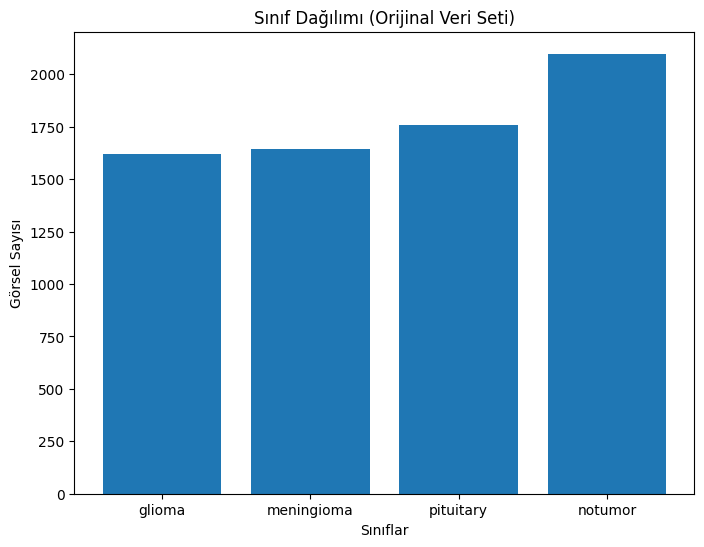

In [9]:
# Sınıf dağılımını görselleştirme (Orijinal veri seti)
class_counts = Counter(Y)
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Sınıf Dağılımı (Orijinal Veri Seti)")
plt.xlabel("Sınıflar")
plt.ylabel("Görsel Sayısı")
plt.show()

Tüm sınıflardaki görüntülerin sayısı Counter ile hesaplanır.
Sınıf dağılımı bir çubuk grafikte görselleştirilir.

In [10]:
# Veri çoğaltma işlemi (orijinal veri seti korunur, yeni veri seti oluşturulur)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Her sınıfı ayrı ayrı çoğaltma
augmented_X = []
augmented_Y = []
target_count = max(Counter(Y).values())  # En fazla olan sınıfın örnek sayısı referans alınır

for label in labels:
    class_images = [X[i] for i in range(len(Y)) if Y[i] == label]
    while len(class_images) < target_count:
        augmented_images = next(datagen.flow(np.array(class_images), batch_size=len(class_images)))
        class_images.extend(augmented_images[:(target_count - len(class_images))])
    augmented_X.extend(class_images)
    augmented_Y.extend([label] * target_count)

Veri setindeki sınıflar arasında dengesizlik varsa, her sınıfı aynı sayıda görüntüye sahip olacak şekilde dengeler.

Örnek Durum: Eğer "glioma" sınıfında 1000 görüntü ve "notumor" sınıfında 2000 görüntü varsa, "glioma" için 1000 yeni görüntü üretilir.
Veri çoğaltma işlemi tamamlandıktan sonra, augmented_X ve augmented_Y listeleri dengelenmiş ve çeşitlendirilmiş bir veri seti oluşturur.

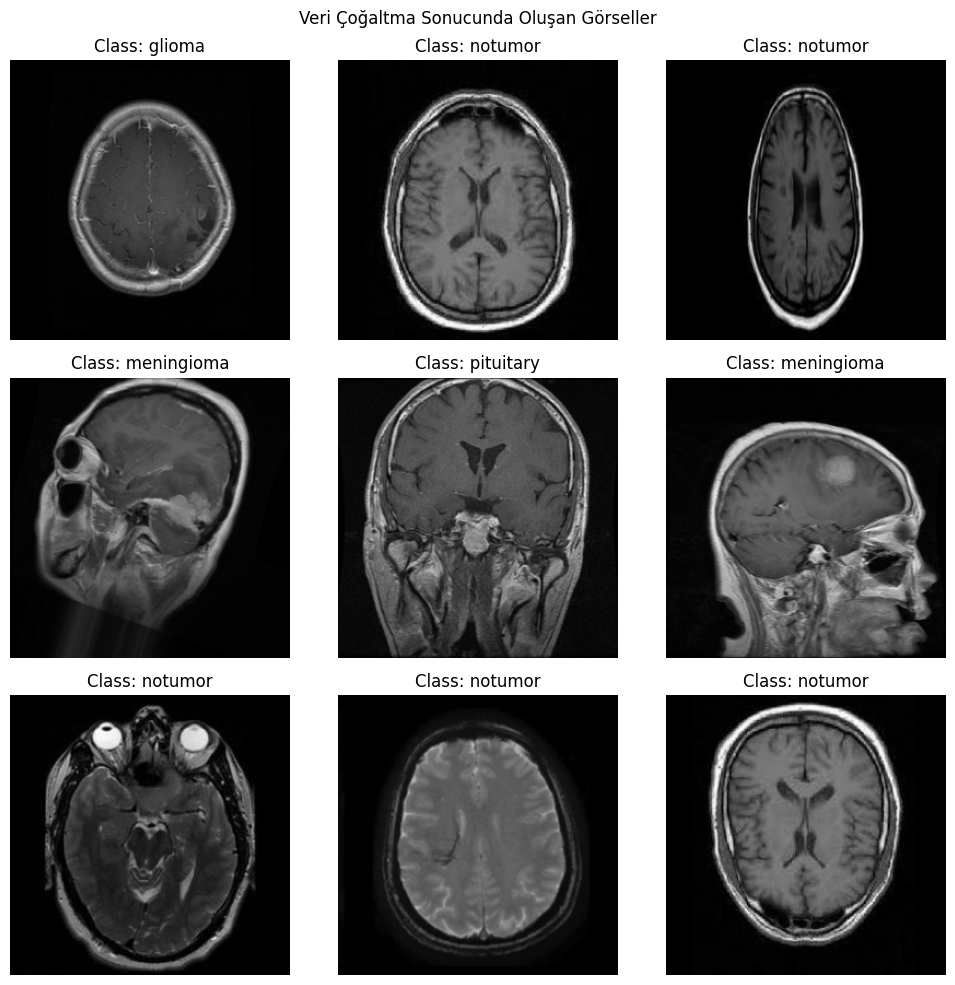

In [16]:
# Çoğaltılmış görsellerden birkaçını seçip görselleştirme
plt.figure(figsize=(10, 10))
random_indices = random.sample(range(len(augmented_X)), 9) 
for i, idx in enumerate(random_indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_X[idx].astype('uint8'))  
    plt.title(f"Class: {augmented_Y[idx]}")
    plt.axis('off')

plt.suptitle("Veri Çoğaltma Sonucunda Oluşan Görseller")
plt.tight_layout()
plt.show()

Bu kısımda:

ImageDataGenerator kullanarak veri çoğaltma işlemi tanımlandı.
Görseller döndürme, kaydırma, yakınlaştırma ve yatay çevirme gibi işlemlerle çoğaltıldı.
Çoğaltılmış görüntüler görselleştirildi.

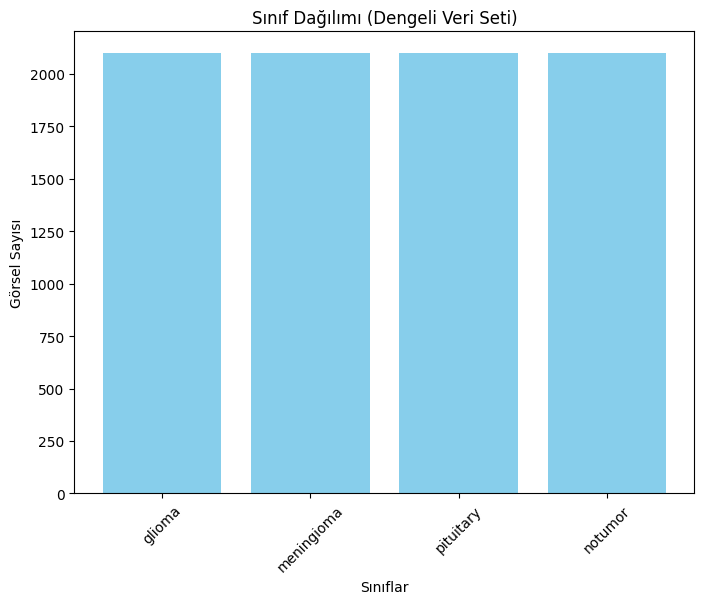

In [17]:
# Dengelenmiş veri kümesinin sınıf dağılımını görselleştirme
balanced_class_counts = Counter(augmented_Y)
plt.figure(figsize=(8, 6))
plt.bar(balanced_class_counts.keys(), balanced_class_counts.values(), color='skyblue')
plt.title("Sınıf Dağılımı (Dengeli Veri Seti)")
plt.xlabel("Sınıflar")
plt.ylabel("Görsel Sayısı")
plt.xticks(rotation=45)
plt.show()

In [19]:
# Veri düzleştirme (flatten) işlemi
augmented_X_flatten = [img.flatten() for img in augmented_X]

# Veri tipi dönüşümü: float32'den uint8'e
augmented_X = np.array(augmented_X, dtype=np.uint8)  # Görüntüler için daha az bellek kullanan uint8 tipi
augmented_X_flatten = np.array(augmented_X_flatten, dtype=np.uint8)

# Yeni veri setini kaydetme (orijinal veri setine zarar vermeden)
output_dir = 'dataset/augmented_data'
os.makedirs(output_dir, exist_ok=True)
np.save(os.path.join(output_dir, 'X_augmented.npy'), augmented_X)
np.save(os.path.join(output_dir, 'Y_augmented.npy'), augmented_Y)
np.save(os.path.join(output_dir, 'X_flatten.npy'), augmented_X_flatten)

print(f"Yeni veri seti '{output_dir}' dizinine başarıyla kaydedildi.")

Yeni veri seti 'dataset/augmented_data' dizinine başarıyla kaydedildi.


Görüntüleri düzleştirir (flatten).
Görüntülerin ve düzleştirilmiş verilerin veri tipini optimize eder (float32 → uint8).
Verileri belirtilen dizine .npy formatında kaydeder.
Orijinal veri setine zarar vermeden çoğaltılmış ve optimize edilmiş bir veri seti oluşturur.
Bu işlem, daha sonraki model eğitim süreçlerinde veri yükleme ve kullanma işlemlerini hızlı ve kolay hale getirir.